In [46]:
from torchvision.utils import save_image
import pandas as pd
from PIL import Image

from osgeo import gdal, osr, ogr

import os

import matplotlib.pyplot as plt
import matplotlib.image as pimage
import numpy as np
import torch

from gtif import *
from dataPreprocess import *

In [47]:
RE = 6371000 #radius of earth
chips_layer_names = []

df = pd.read_csv(r"C:\Users\mouju\Desktop\film\components_analysis\df_unique.csv", header=[0])
project_df(df)

In [8]:
df.proj_x.max()

-2259865.6402677717

In [9]:
df.proj_x.min()

-2369689.1843294236

In [10]:
df.proj_y.min()

-83636.26810386151

In [11]:
df.proj_y.max()

-48035.44244709332

In [48]:


df.borehole = df.borehole.str.replace('//', '--')

file = r"C:\Users\mouju\Desktop\film\hds\geotiff_original\ldcorr_refine.tif"
ds = gdal.Open(os.path.join(data_root, file))
ulx, xres, xskew, uly, yskew, yres  = ds.GetGeoTransform()

band = ds.GetRasterBand(1)
arr = band.ReadAsArray()

df = crop_df_hds(df)

print(f'Number of boreholes: {len(df)}')

Number of boreholes: 163


In [55]:
df['borehole_group'] = df['borehole'].str.split('-').str[0]

df=df.query("borehole_group != '2.45'")

df=df.query("borehole_group != 'GSC3 '")

df=df.query("borehole_group != 'GSC4 '")

df=df.query("borehole != 'ENG.YARC03097-01--ITH-02'")
df=df.query("borehole != 'ENG.YARC03097-01--ITH-03'")

df=df.query("borehole != 'ENG.YARC03097-01--ITH-04'")

df=df.query("borehole != 'W14103137-CR18N'")
df=df.query("borehole != 'W14103137-CR18S'")
df=df.query("borehole != 'W14103137-CR21N'")
df=df.query("borehole != 'W14103137-CR21S'")

In [56]:
print(f'Number of boreholes: {len(df)}')

Number of boreholes: 84


In [10]:
# make sure boreholes fall within hds region

# # plt.fig()
# plt.imshow(arr)
# plt.colorbar()
# plt.title(file)
# ax = plt.gca()
# ax.get_yaxis().set_visible(False)
# ax.get_xaxis().set_visible(False)

# x_scatter = (df.longitude - ulx) / xres
# y_scatter = (uly - df.latitude)/(-yres)
# plt.scatter(x_scatter, y_scatter,c='r')
# plt.show()

# ARCTICDEM

In [11]:
chip_size = 128

data_root = r"C:\Users\mouju\Desktop\film\saga_data"

chips_root = r"C:\Users\mouju\Desktop\film\raster_chips_arcticdem"
if not os.path.exists(chips_root):
    os.makedirs(chips_root)

chips_image_root = chips_root + "_images"

if not os.path.exists(chips_image_root):
    os.makedirs(chips_image_root)

n_channels = len(os.listdir(data_root)) // 2

# base_lat = 70
# base_lng = -135


# # lenght along meridians
# pixel_len_lat = 5/180 * np.pi /6000 * RE # in meters
# chip_size_m = 5000 # chip size in meters
# chip_size_lat = round(chip_size_m/pixel_len_lat/2) * 2 # making sure chip_size is even

n_pixels = 10000
base_x = -2399995
preloaded = np.zeros([n_channels, n_pixels, n_pixels*2])
file_list = os.listdir(data_root)

In [13]:
for i in range(n_channels):
    # name = file.split('_')[0]
    # print(name)
    f_17 = os.path.join(data_root, file_list[i*2])
    f_18 = os.path.join(data_root, file_list[i*2 + 1])
    
    arr17, extent17, _ = read_geotiff(f_17, 1)
    
    #print(extent17)
    arr18, _, _ = read_geotiff(f_18, 1)
    
    preloaded[i, :, 0:10000] = arr17
    preloaded[i,:, 10000:20000] = arr18
    
    channel_name = file_list[i*2].split('_')[0]
    chips_layer_names.append(channel_name)

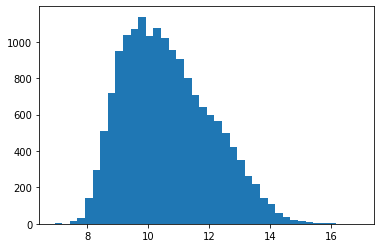

In [15]:
plt.figure()
for _, row in df.iterrows():
    
    x = row.at['proj_x']
    y = row.at['proj_y']
    bh = row.borehole

    pixel_len = 10


    # (df17.proj_x + 2400000) / 10, (-df17.proj_y)/10

    x_start = np.round((x - base_x) / pixel_len - chip_size/2).astype(int)
    x_end = x_start + chip_size

    y_start = np.round((- y) / pixel_len - chip_size/2).astype(int)
    y_end = y_start + chip_size
    
#     print(x, base_x)
#     print(x - base_x)
    # print(x_start,x_end,y_start,y_end)
    
    if (y_end - y_start < chip_size) or (x_end - x_start < chip_size):
        print(f'chip size of {bh} smaller than desired chip size')
    
    image= preloaded[:, y_start:y_end, x_start:x_end]
    
    with open(os.path.join(chips_root, f'{bh}.npy'), 'wb') as f:
        np.save(f, image)
    
    for i in range(n_channels):
        channel_name = file_list[i*2].split('_')[0]
        
        channel_path = os.path.join(chips_image_root, channel_name)
        if not os.path.exists(channel_path):
            os.makedirs(channel_path)
        
        pimage.imsave(os.path.join(channel_path, f'{bh}.png'), image[i,:,:])
        
        plt.clf()
        plt.hist(image[i,:,:].flatten(), bins=40)
        plt.savefig(os.path.join(channel_path, f'{bh}_hist.png'))
    

# HDS (rgb channels?)

In [63]:
chip_size = 128
data_root = r"C:\Users\mouju\Desktop\film\hds\geotiff_med"
chips_root = r"C:\Users\mouju\Desktop\film\raster_chips\hds"
if not os.path.exists(chips_root):
    os.makedirs(chips_root)
print_progress = False

In [64]:
file_list = os.listdir(data_root)
# file_list_rgb = []
# for f in file_list:
#     for colour in ['r', 'g', 'b']:
#         file_list_rgb.append(f.split('_')[0] + '_' + colour)
n_channels = len(file_list*3)

f = os.path.join(data_root, file_list[0])
arr, extent, _ = read_geotiff(f, 1)
ulx, xres, xskew, uly, yskew, yres = extent

preloaded = np.zeros([n_channels, arr.shape[0], arr.shape[1]])
print(f"xres = {xres}, yres = {yres}, ulx = {ulx}, uly = {uly}")

channel_names_list = []
for i, file in enumerate(file_list):
    name = file.split('_')[0]
    f = os.path.join(data_root, file)
    for c_ind, colour in enumerate(['r', 'g', 'b']):
        channel_names_list.append(name + "_" + colour)
        arr, extent, _ = read_geotiff(f, c_ind+1)
        preloaded[i*3 + c_ind, :, :] = arr

xres = 10.0, yres = -10.0, ulx = -2358227.0324422084, uly = -45050.27319812629


In [65]:
channel_names_list

['ldcorr_r', 'ldcorr_g', 'ldcorr_b', 'tdpcorr_r', 'tdpcorr_g', 'tdpcorr_b']

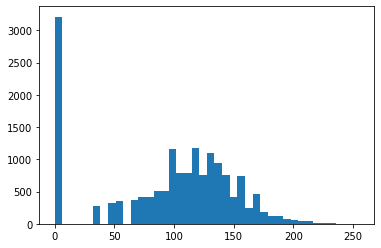

In [66]:
plt.figure()
for bh_ind, row in df.iterrows():
    
    x = row.at['proj_x']
    y = row.at['proj_y']
    bh = row.borehole
    if print_progress:
        print(f"borehole {bh_ind} {bh}")

    x_start = np.round((x - ulx) / xres - chip_size/2).astype(int)
    x_end = x_start + chip_size

    y_start = np.round((y - uly) / yres - chip_size/2).astype(int)
    y_end = y_start + chip_size
    
    if (y_end - y_start < chip_size) or (x_end - x_start < chip_size):
        print(f'chip size of {bh} smaller than desired chip size')


    image= preloaded[:, y_start:y_end, x_start:x_end]
    with open(os.path.join(chips_root, f'{bh}.npy'), 'wb') as f:
        np.save(f, image)
    
    for i in range(n_channels):
        channel_name = channel_names_list[i]
        if print_progress:
            print(f'channel {channel_name}')
        channel_path = os.path.join(chips_root+'_images', channel_name)
        if not os.path.exists(channel_path):
            os.makedirs(channel_path)
        
        pimage.imsave(os.path.join(channel_path, f'{bh}.png'), image[i,:,:])
        
        plt.clf()
        plt.hist(image[i,:,:].flatten(), bins=40)
        plt.savefig(os.path.join(channel_path, f'{bh}_hist.png'))

# GEO 90

In [ ]:
# intakes raster layers already in epsg 3413 coordinate, 10m resolution

In [11]:
chip_size = 128
data_root = r"C:\Users\mouju\Desktop\film\geomorph_data_epsg3413_10m"
chips_root = r"C:\Users\mouju\Desktop\film\raster_chips\geo90"
if not os.path.exists(chips_root):
    os.makedirs(chips_root)
print_progress = False

In [17]:
file_list = os.listdir(data_root)
n_channels = len(file_list)

f = os.path.join(data_root, file_list[0])
arr, extent, _ = read_geotiff(f, 1)
ulx, xres, xskew, uly, yskew, yres = extent

preloaded = np.zeros([n_channels, arr.shape[0], arr.shape[1]])
print(f"xres = {xres}, yres = {yres}, ulx = {ulx}, uly = {uly}")

channel_names_list = []
for i, file in enumerate(file_list):
    name = file.split('_')[0]
    channel_names_list.append(name)
    f = os.path.join(data_root, file)
    arr, extent, _ = read_geotiff(f, 1)
    
    preloaded[i, :, :] = arr

xres = 10.0, yres = -10.0, ulx = -2371005.0, uly = -47000.0


borehole 108 2.45-1-1
channel aspect-cosine
channel aspect-sine
channel aspect
channel convergence
channel cti
channel dev-magnitude
channel dev-scale
channel dxx
channel dxy
channel dx
channel dyy
channel dy
channel eastness
channel elev-stdev
channel northness
channel pcurv
channel rough-magnitude
channel rough-scale
channel roughness
channel slope
channel spi
channel tcurv
channel tpi
channel tri
channel vrm
borehole 109 2.45-1-11
channel aspect-cosine
channel aspect-sine
channel aspect
channel convergence
channel cti
channel dev-magnitude
channel dev-scale
channel dxx
channel dxy
channel dx
channel dyy
channel dy
channel eastness
channel elev-stdev
channel northness
channel pcurv
channel rough-magnitude
channel rough-scale
channel roughness
channel slope
channel spi
channel tcurv
channel tpi
channel tri
channel vrm
borehole 110 2.45-1-12
channel aspect-cosine
channel aspect-sine
channel aspect
channel convergence
channel cti
channel dev-magnitude
channel dev-scale
channel dxx
chann

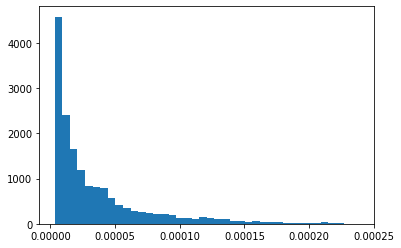

In [19]:
plt.figure()
for bh_ind, row in df.iterrows():
    
    x = row.at['proj_x']
    y = row.at['proj_y']
    bh = row.borehole
    if print_progress:
        print(f"borehole {bh_ind} {bh}")

    x_start = np.round((x - ulx) / xres - chip_size/2).astype(int)
    x_end = x_start + chip_size

    y_start = np.round((y - uly) / yres - chip_size/2).astype(int)
    y_end = y_start + chip_size
    
    if (y_end - y_start < chip_size) or (x_end - x_start < chip_size):
        print(f'chip size of {bh} smaller than desired chip size')


    image= preloaded[:, y_start:y_end, x_start:x_end]
    with open(os.path.join(chips_root, f'{bh}.npy'), 'wb') as f:
        np.save(f, image)
    
    for i in range(n_channels):
        channel_name = file_list[i].split('_')[0]
        if print_progress:
            print(f'channel {channel_name}')
        channel_path = os.path.join(chips_root+'_images', channel_name)
        if not os.path.exists(channel_path):
            os.makedirs(channel_path)
        
        pimage.imsave(os.path.join(channel_path, f'{bh}.png'), image[i,:,:])
        
        plt.clf()
        plt.hist(image[i,:,:].flatten(), bins=40)
        plt.savefig(os.path.join(channel_path, f'{bh}_hist.png'))

# Normalize chips

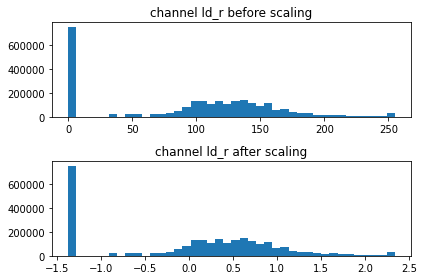

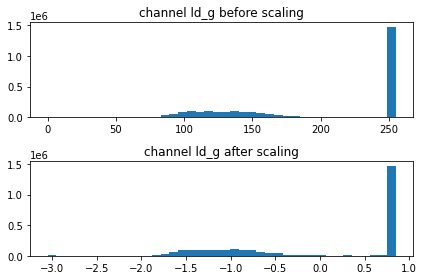

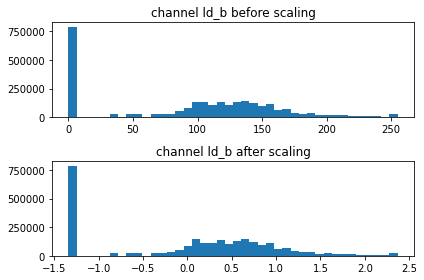

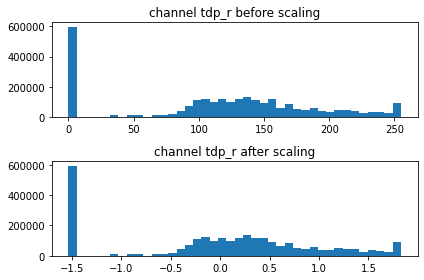

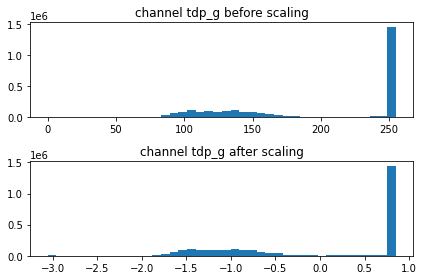

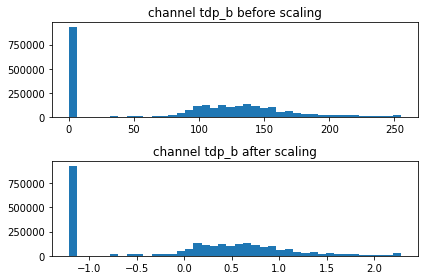

In [30]:
normalize_chips(chips_root, channel_names_list)